# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 6 - RNNs



**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [4]:
# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)

<div class="theme"> Part 1: Data </div>
Read `HW6_data.csv` into a pandas dataframe using the provided code below.

In [5]:
# Given code
path_dataset = './data/HW6_data.csv'
data = pd.read_csv(path_dataset,
                   encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity


<div class='exercise'><b> Question 1: Data [20 points total]</b></div>

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 
**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`
 
**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

**1.12** Split the dataset into train and test sets (test 10%).

## Answers

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

In [6]:
# your code here
words = np.unique(data.Word).tolist()
words.sort()
words.append("ENDPAD")
n_words = len(words)

In [7]:
# Run this cell to show your results for n_words
print(n_words)

35179


**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

In [8]:
# your code here
tags = np.unique(data.Tag).tolist()
tags.sort()
tags.append("PAD")
n_tags = len(tags)

In [9]:
# Run this cell to show your results for n_tags
print(n_tags)

18


**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 

In [10]:
# your code here
grouped = data.groupby(["Sentence #"])
sentences = []
for i,group in enumerate(grouped):
    subdata = group[1]
    sentence = [tuple(x) for x in subdata[['Word','Tag']].to_numpy()]
    sentences.append(sentence)
sentences[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

In [11]:
# your code here
max_len = np.max(list(map(len,sentences)))

In [12]:
# Run this cell to show your results for max_len
print(max_len)

104


**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

In [13]:
# your code here
word2idx = dict((word,i) for i,word in enumerate(words))
idx2word = dict((i,word) for i,word in enumerate(words))

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

In [14]:
# your code here
X = []
for sentence in sentences:
    sentence2id = []
    for word in sentence:
        sentence2id.append(word2idx[word[0]])
    X.append(sentence2id)

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`

In [15]:
# your code here
X = pad_sequences(X, maxlen=max_len,padding='post',value=word2idx['ENDPAD'])

In [16]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

In [17]:
# your code here
tag2idx = dict((tag,i) for i,tag in enumerate(tags))
idx2tag = dict((i,tag) for i,tag in enumerate(tags))

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

In [18]:
# your code here
y = []
for sentence in sentences:
    sentence2tagid = []
    for word in sentence:
        sentence2tagid.append(tag2idx[word[1]])
    y.append(sentence2tagid)

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

In [19]:
# your code here
y = pad_sequences(y, maxlen=max_len,padding='post',value=tag2idx['PAD'])

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

In [20]:
# your code here
Y = to_categorical(y)

In [21]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(y[0][-1]))
print(np.array(y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: 17

(47959, 104)


**1.12** Split the dataset into train and test sets (test 10%).

In [22]:
# your code here
split_at = len(X) - len(X) // 10
X_tr, X_te, y_tr, y_te = X[:split_at], X[split_at:],Y[:split_at],Y[split_at:]

## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [23]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [24]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40 points total]</b></div>

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


**2.2a** Explain what the embedding layer is and why we need it here.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

## Answers

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


In [25]:
# your code here
baseline = np.zeros(n_words)
mywords = words.copy()
mywords.remove('ENDPAD')
word_tag_occurence = data.groupby(['Word','Tag']).count()
for w in mywords:
    myword = word_tag_occurence.loc[w]
    baseline[word2idx[w]] = tag2idx[myword.index[myword['Sentence #'].values.argmax()]]
baseline[word2idx['ENDPAD']]=tag2idx['PAD']

In [26]:
# Run this cell to show your results #
print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in baseline[X[0]]]))

(47959, 104) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDP

**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


### Use these hyperparameters for all NN models

In [27]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [28]:
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [29]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
dense (Dense)                (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38847 samples, validate on 4317 samples
Epoch 1/10
38847/38847 [==============================] - 16s 417us/sample - loss: 0.3149 - accuracy: 0.9787 - val_loss: 0.0611 - val_accuracy: 0.9855
Epoch 2/10
38847/38847 [==============================] - 15s 386us/sample - loss: 0.0513 - accuracy: 0.9863 - val_loss: 0.0496 - val_accuracy: 0.9865
Epoch 3/10
38847/38847 [==============================] - 15s 381us/sample - loss: 0.0449 - accuracy: 0.9873 - val_loss: 0.0469 - val_accuracy: 0.9871
Epoch 4/10
38847/38847 [==============================] - 15s 377us/sample - loss: 0.0426 - accuracy: 0.9878 - val_loss: 0.0456 - val_accuracy: 0.9874
Epoch 5/10
38847/38847 [==============================] - 14s 368us/sample - loss: 0.0413 - accuracy: 0.9882 - val_loss: 0.0449 - val_accuracy: 0.9875
Epoch 6/10
38847/38847 [==============================] - 14s 371us/sample - loss: 0.0404 - accuracy: 0.9884 - val_loss: 0.0444 - val_accuracy: 0.9877
Epoch 7/10
38847/38847 [=====================

In [31]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


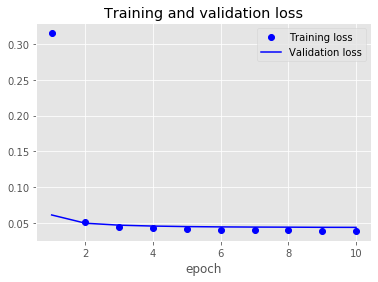

In [32]:
plot_training_history(history)

**2.2a** Explain what the embedding layer is and why we need it here.

*your answer here*

The embedding layer is a dense layer that maps the original word vectors represented by one-hot vectors to embeddings. The one-hot vector is sparse with only one element to be one, indicating the word represented by this vector. To represent all words in the vocabulary, the one-hot vector needs a dimension of vocabulary size, therefore it is high dimensional. On the contary, the embedding is dense whith a dimension pre-spercified, much smaller than the original vocabulary size. Reducing the dimension of vectors used for representing words could reduce the number of parameters needed for the model. Moreover, the relative position between embeddings delivers semantic meaning, that is, the words with similar meanings are more likely to have embeddings close to each other. Hence, visualizing the embeddings would be helful for inferring how well the network learns.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

*your answer here*

As argued in 2.2a, the embedding layer is indeed a dense layer which maps the one-hot vector to embeddings. Since the vocabulary size is 35179, and each word has its embedding with dimension 50 (as pre-specified), therefore, the embedding layer is a matrix with dimension 35179*50=1758950.

### Viewing Hidden Layers
In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that this code and the parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [33]:
FFNN = load_keras_model("model_FFNN")
def create_truncated_model_FFNN(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(tf.keras.layers.Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(X_te)

# flatten data
hidden_features = hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9396784632326867


In [34]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te.reshape(-1,18), axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

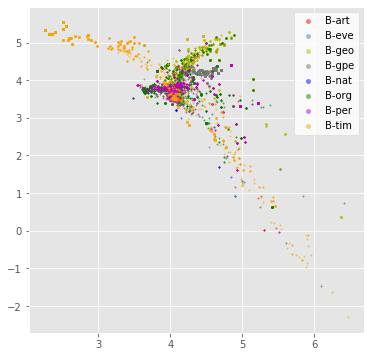

In [35]:
visualize_hidden_features(pca_result)

### Full function for other questions ###

In [36]:
def get_hidden_output_PCA(model,X_te,y_te,layer_index,out_dimension):
    output = tf.keras.backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([X_te]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [37]:
def visualize_B_I(pca_result):
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in range(8*i,8*(i+1)):
            indices = np.where(category==cat)[0]
            ax[i].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2tag[cat],s=2,color=color[cat-8*i],alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("first dimension")
        ax[i].set_ylabel("second dimension")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
    plt.show()

Variance explained by PCA: 0.9396900931548118


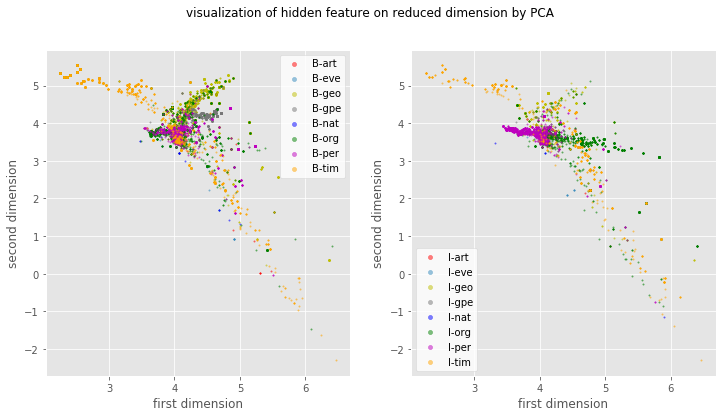

In [38]:
h = get_hidden_output_PCA(FFNN,X_te,y_te,1,50)
visualize_B_I(h)

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

In [39]:
# your code here
model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(SimpleRNN(100,return_sequences=True))
model.add(TimeDistributed(Dense(n_tags, activation='softmax')))
# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [40]:
history_RNN = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38847 samples, validate on 4317 samples
Epoch 1/10
38847/38847 [==============================] - 82s 2ms/sample - loss: 0.0928 - accuracy: 0.9776 - val_loss: 0.0342 - val_accuracy: 0.9901
Epoch 2/10
38847/38847 [==============================] - 80s 2ms/sample - loss: 0.0294 - accuracy: 0.9913 - val_loss: 0.0303 - val_accuracy: 0.9910
Epoch 3/10
38847/38847 [==============================] - 81s 2ms/sample - loss: 0.0260 - accuracy: 0.9923 - val_loss: 0.0288 - val_accuracy: 0.9915
Epoch 4/10
38847/38847 [==============================] - 81s 2ms/sample - loss: 0.0243 - accuracy: 0.9928 - val_loss: 0.0286 - val_accuracy: 0.9917
Epoch 5/10
38847/38847 [==============================] - 80s 2ms/sample - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.0288 - val_accuracy: 0.9914
Epoch 6/10
38847/38847 [==============================] - 80s 2ms/sample - loss: 0.0221 - accuracy: 0.9934 - val_loss: 0.0284 - val_accuracy: 0.9917
Epoch 7/10
38847/38847 [==============================] -

In [41]:
# save your mode #
store_keras_model(model, 'model_RNN')

Saved model to disk


In [42]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_2 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 104, 100)          15100     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________
None


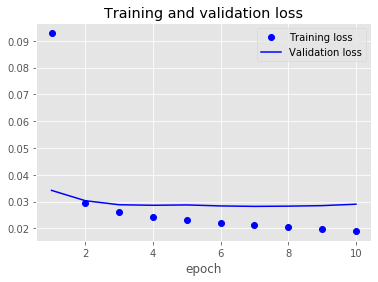

In [43]:
# run this cell to show your results #
plot_training_history(history_RNN)

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

Variance explained by PCA: 0.9799511262265265


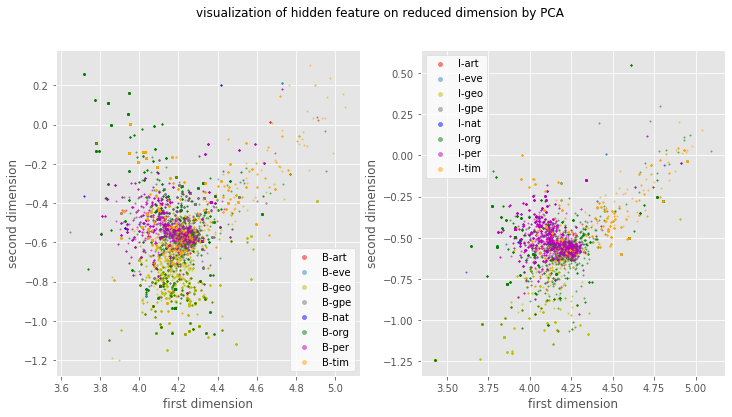

In [44]:
# your code here
RNN = load_keras_model("model_RNN")
h = get_hidden_output_PCA(RNN,X_te,y_te,1,50)
visualize_B_I(h)

Variance explained by PCA: 0.8401182934301761


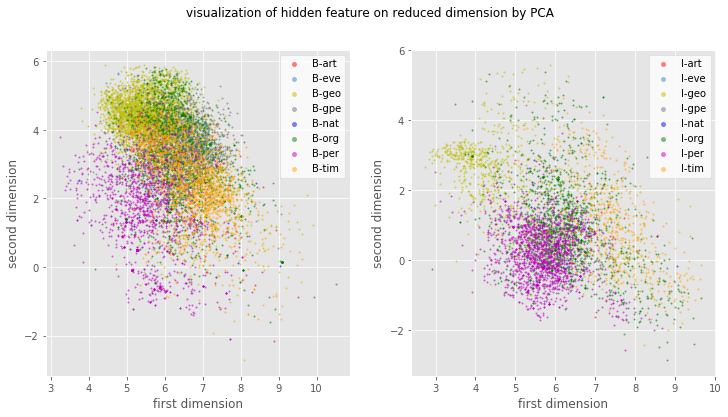

In [45]:
h = get_hidden_output_PCA(RNN,X_te,y_te,2,n_units)
visualize_B_I(h)

*your answer here*

Both the outputs of embedding layer and the RNN layer are visualized here. From the plot of word embeddings we can see that those frequent tags (e.g. B-per and I-per) follow their own distributions pattern hence look like they are well-clustered into seperated groups though we are not running clustering algorithmn. This makes sense as the words in different tags tend to have different semantic meaning, therefore having different embeddings while words in the same tag tend to have similar meaning and therefore are close to each other. The clustering pattern is much stronger than the result of FFNN. This kind of clustering is further improved aftering going through the RNN layer, that is, the clustering pattern becomes stronger when we visualize the RNN layer output below. However, for less-frequent tags such as, B-art, B-nat, I-art, I-eve, I-gpe and I-nat, they can hardly be spotted in the scatter plot of embedding space and they don't tend to be grouped togather, which implies that they spread through the entire feature space and are poorly clustered. Hence, our network fails to learn a good embedding for words with less frequent tags.

<div class='explication'> </div>

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

*your answer here*

A Gated Recurrent Unit (GRU) is a gating mechanism in recurrent neural networks. The GRU has fewer parameters than LSTM, as it combines the input and forget gate and it has no state. The difference between a GRU and a simple RNN is that, a simple RNN can only keep a fixed size of state which has a short term memories of previous inputs, but the GRU avoids vanishing gradint problem by keeping both unfixed long-term and short-term memory from the previous inputs.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

In [46]:
# your code here
model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(GRU(100,return_sequences=True))
model.add(TimeDistributed(Dense(n_tags, activation='softmax')))
# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [47]:
history_GRU = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38847 samples, validate on 4317 samples
Epoch 1/10
38847/38847 [==============================] - 41s 1ms/sample - loss: 0.0887 - accuracy: 0.9780 - val_loss: 0.0331 - val_accuracy: 0.9903
Epoch 2/10
38847/38847 [==============================] - 38s 977us/sample - loss: 0.0289 - accuracy: 0.9914 - val_loss: 0.0298 - val_accuracy: 0.9910
Epoch 3/10
38847/38847 [==============================] - 37s 965us/sample - loss: 0.0258 - accuracy: 0.9923 - val_loss: 0.0283 - val_accuracy: 0.9915
Epoch 4/10
38847/38847 [==============================] - 38s 968us/sample - loss: 0.0240 - accuracy: 0.9929 - val_loss: 0.0277 - val_accuracy: 0.9917
Epoch 5/10
38847/38847 [==============================] - 38s 970us/sample - loss: 0.0228 - accuracy: 0.9932 - val_loss: 0.0276 - val_accuracy: 0.9917
Epoch 6/10
38847/38847 [==============================] - 38s 971us/sample - loss: 0.0218 - accuracy: 0.9935 - val_loss: 0.0274 - val_accuracy: 0.9918
Epoch 7/10
38847/38847 [=======================

In [48]:
# save your model #
store_keras_model(model, 'model_GRU')

Saved model to disk


In [49]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_3 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru (GRU)                    (None, 104, 100)          45600     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,806,368
Trainable params: 1,806,368
Non-trainable params: 0
_________________________________________________________________
None


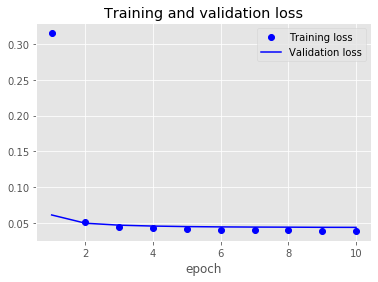

In [50]:
# run this cell to show your results #
plot_training_history(history)

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.9630003293943247


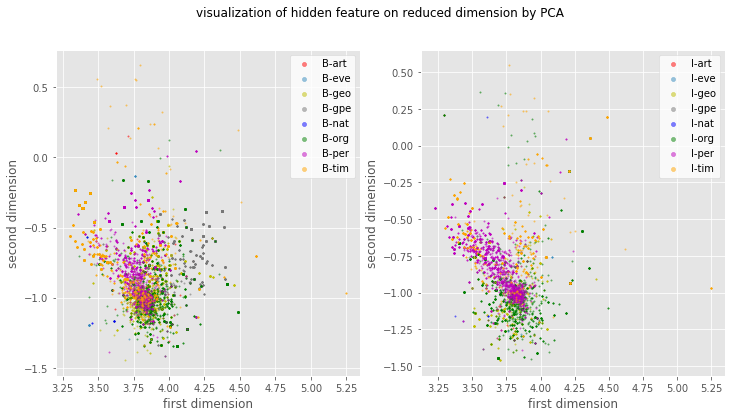

In [51]:
# your code here
myGRU = load_keras_model("model_GRU")
h = get_hidden_output_PCA(myGRU,X_te,y_te,1,50)
visualize_B_I(h)

Variance explained by PCA: 0.7544090937738481


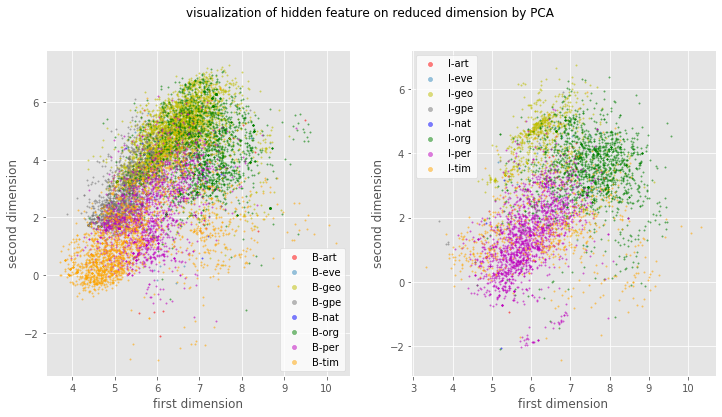

In [52]:
h = get_hidden_output_PCA(myGRU,X_te,y_te,2,100)
visualize_B_I(h)

*your answer here*

Like in 2.3b, both the outputs of embedding layer and the RNN layer are visualized here. The plots are similar to those in 2.3b, i.e., frequent tags are well-clustered as words with same tags having similar distributions. The clustering pattern is much stronger than the result of FFNN and slightly better than that of simple RNN. However, GRU suffers the same problem of simple RNN, that is, for less-frequent tags such as, B-art, B-nat, I-art, I-eve, I-gpe and I-nat, they can still hardly be spotted in the scatter plot of embedding space and they don't tend to be grouped togather, which implies that they spread through the entire feature space and are poorly "clustered". Hence, GRU fails to learn good embeddings/distributions for words with less frequent tags therefore failing to classify those tags well.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.



*your answer here*

A Bidirectional GRU is two layers of GRUs stacking togather with one layer taking input forwards while the other taking input backwards.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.


In [53]:
# your code here
model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(Bidirectional(GRU(100,return_sequences=True)))
model.add(TimeDistributed(Dense(n_tags, activation='softmax')))
# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [54]:
history_BiGRU = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38847 samples, validate on 4317 samples
Epoch 1/10
38847/38847 [==============================] - 73s 2ms/sample - loss: 0.0728 - accuracy: 0.9816 - val_loss: 0.0285 - val_accuracy: 0.9918
Epoch 2/10
38847/38847 [==============================] - 69s 2ms/sample - loss: 0.0241 - accuracy: 0.9929 - val_loss: 0.0254 - val_accuracy: 0.9926
Epoch 3/10
38847/38847 [==============================] - 69s 2ms/sample - loss: 0.0207 - accuracy: 0.9939 - val_loss: 0.0239 - val_accuracy: 0.9930
Epoch 4/10
38847/38847 [==============================] - 69s 2ms/sample - loss: 0.0189 - accuracy: 0.9945 - val_loss: 0.0237 - val_accuracy: 0.9930
Epoch 5/10
38847/38847 [==============================] - 69s 2ms/sample - loss: 0.0176 - accuracy: 0.9948 - val_loss: 0.0237 - val_accuracy: 0.9929
Epoch 6/10
38847/38847 [==============================] - 69s 2ms/sample - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.0233 - val_accuracy: 0.9931
Epoch 7/10
38847/38847 [==============================] -

In [55]:
# save your model #
store_keras_model(model, 'model_BiGRU')

Saved model to disk


In [56]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_4 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 200)          91200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 18)           3618      
Total params: 1,853,768
Trainable params: 1,853,768
Non-trainable params: 0
_________________________________________________________________
None


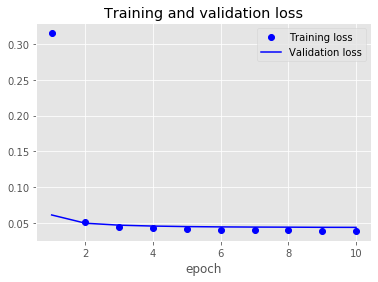

In [57]:
# run this cell to show your results #
plot_training_history(history)

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.8119186479175229


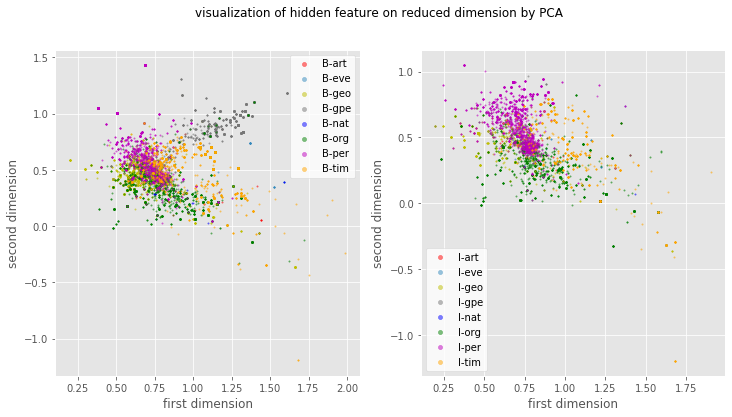

In [58]:
# your code here
BiGRU = load_keras_model("model_BiGRU")
h = get_hidden_output_PCA(BiGRU,X_te,y_te,1,50)
visualize_B_I(h)

Variance explained by PCA: 0.7740672318744745


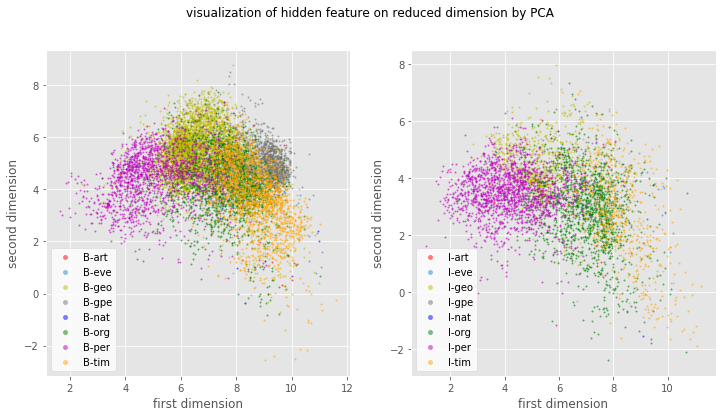

In [59]:
h = get_hidden_output_PCA(BiGRU,X_te,y_te,2,200)
visualize_B_I(h)

*your answer here*

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

**3.3** Briefly discuss the performance of each model


**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.


## Answers

**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

In [60]:
# your code here
label_te = y[split_at:]
r,c = X_te.shape
baseline_te_pre = np.zeros(label_te.shape)
for i in range(r):
    for j in range(c):
        baseline_te_pre[i,j] = baseline[X_te[i,j]]
baseline_F1 = f1_score(label_te.flatten(),baseline_te_pre.flatten(), average=None)

FFNN = load_keras_model("model_FFNN")
pred_FFNN = np.argmax(FFNN.predict(X_te),axis=2)
FFNN_F1 = f1_score(label_te.flatten(), pred_FFNN.flatten(), average=None)

RNN = load_keras_model("model_RNN")
pred_RNN = np.argmax(RNN.predict(X_te),axis=2)
RNN_F1 = f1_score(label_te.flatten(), pred_RNN.flatten(), average=None)

BiGRU = load_keras_model("model_BiGRU")
pred_BiGRU = np.argmax(BiGRU.predict(X_te),axis=2)
BiGRU_F1 = f1_score(label_te.flatten(), pred_BiGRU.flatten(), average=None)

myGRU = load_keras_model("model_GRU")
pred_GRU = np.argmax(myGRU.predict(X_te),axis=2)
GRU_F1 = f1_score(label_te.flatten(), pred_GRU.flatten(), average=None)

/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [61]:
models = ['baseline','FFNN','RNN','GRU','BiGRU']
f1_table = pd.DataFrame(columns=models,index=tags)
f1_table['baseline'] = baseline_F1
f1_table['FFNN']=FFNN_F1
f1_table['RNN']=RNN_F1
f1_table['GRU']=GRU_F1
f1_table['BiGRU']=BiGRU_F1
f1_table

,baseline,FFNN,RNN,GRU,BiGRU
B-art,0.417910,0.076923,0.040816,0.000000,0.034483
B-eve,0.524590,0.384615,0.431373,0.431373,0.426230
B-geo,0.840390,0.796575,0.834162,0.840220,0.866189
B-gpe,0.940752,0.915611,0.927234,0.931902,0.936288
B-nat,0.222222,0.222222,0.428571,0.387097,0.444444
B-org,0.653935,0.558224,0.627662,0.638904,0.718138
B-per,0.780398,0.683075,0.795539,0.791264,0.821253
B-tim,0.837661,0.802956,0.862703,0.869216,0.900154
I-art,0.266667,0.000000,0.000000,0.000000,0.000000
I-eve,0.187500,0.129032,0.277778,0.307692,0.171429


**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

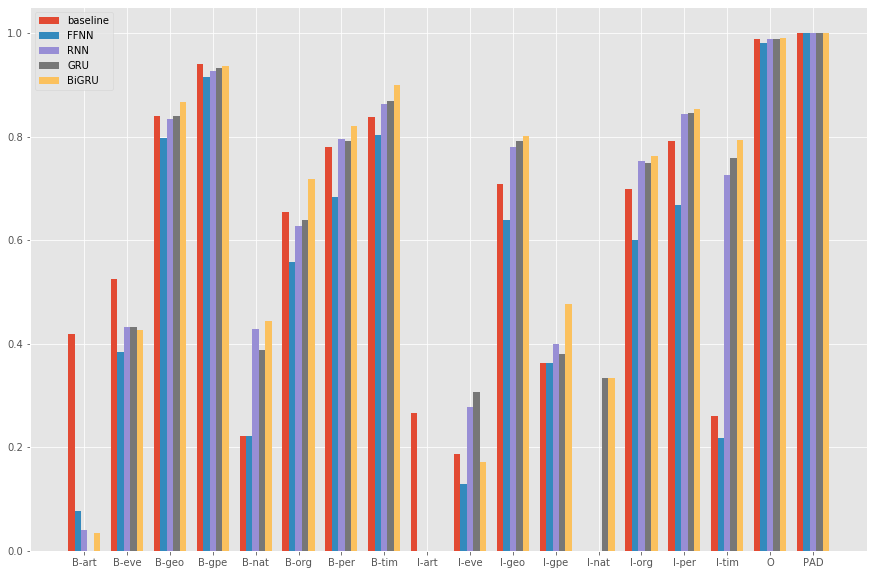

In [62]:
# your code here
t = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
plt.figure(figsize=(15,10))
plt.bar(t-0.3, baseline_F1,alpha=1,width=0.15,label='baseline')
plt.bar(t-0.15, FFNN_F1,alpha=1,width=0.15,label='FFNN')
plt.bar(t, RNN_F1,alpha=1,width=0.15,label='RNN')
plt.bar(t+0.15, GRU_F1,alpha=1,width=0.15,label='GRU')
plt.bar(t+0.3, BiGRU_F1,alpha=1,width=0.15,label='BiGRU')
plt.xticks(t,tags)
plt.legend()

**3.3** Briefly discuss the performance of each model

*your answer here*

Overall, BiGRU model outperforms the rest models in most of the cases and has the most tags (7) having F1 score above 0.8. But in some tags with insufficient number of samples, the BiGRU model may fail to achieve good performance (see B-art, I-art abd I-nat).The FFNN has the worst performance, which is worse than the baseline model.

**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

*your answer here*

My criteria for having low F1 score is defined as no more than two models yield F1 score higher than 0.4. Therefore, B-art, B-nat, I-art, I-eve, I-gpe and I-nat are tags of low accuracy.   

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [63]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [64]:
# your code here
I_art_id = tag2idx['I-art']
for i in range(r):
    for j in range(c):
        if label_te[i,j]==I_art_id and baseline_te_pre[i,j]!=I_art_id and pred_FFNN[i,j] != I_art_id and pred_BiGRU[i,j] != I_art_id and pred_RNN[i,j] != I_art_id and pred_GRU[i,j] != I_art_id:
            wrong_sentence_id = i
            wrong_word_id = j
            break
    else:
        continue
    break

In [65]:
# your code here
wrong_word = [idx2word[w] for w in X_te[wrong_sentence_id,:]]
wrong_result = pd.DataFrame({'Word':wrong_word,
                            'y_true':[idx2tag[label] for label in label_te[wrong_sentence_id,:]],
                            'baseline':[idx2tag[label] for label in baseline_te_pre[wrong_sentence_id,:]],
                            'model_FFNN':[idx2tag[label] for label in pred_FFNN[wrong_sentence_id,:]],
                            'model_RNN':[idx2tag[label] for label in pred_RNN[wrong_sentence_id,:]],
                            'model_GRU':[idx2tag[label] for label in pred_GRU[wrong_sentence_id,:]],
                            'model_BiGRU':[idx2tag[label] for label in pred_BiGRU[wrong_sentence_id,:]]})

In [66]:
# your code here
wrong_result.head().style.apply(highlight_errors,axis=1)

,Word,y_true,baseline,model_FFNN,model_RNN,model_GRU,model_BiGRU
0,The,B-org,O,O,O,O,O
1,Wall,B-art,I-org,I-org,B-org,B-org,B-org
2,Street,I-art,I-org,I-org,I-org,I-org,I-org
3,Journal,I-art,I-org,I-org,I-org,I-org,I-org
4,reports,O,O,O,O,O,O


**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

In [67]:
# your code here
#from tensorflow.keras.optimizers import Adam
n_units = 150
drop_rate = .1
dim_embed = 100

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]
batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1
model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(Bidirectional(GRU(n_units,return_sequences=True)))
#model.add(BatchNormalization())
#model.add(Bidirectional(GRU(n_units,return_sequences=True)))
#model.add(Bidirectional(LSTM(n_units,return_sequences=True)))
model.add(TimeDistributed(Dense(n_tags, activation='softmax')))
# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [68]:
tag_count =y_tr.sum(axis=0).sum(axis=0)
interest_tags = []
for i,j in enumerate(tag_count):
    if 5000<= j <= 25000:
        interest_tags.append(i)
weight = y_tr[:,:,list(interest_tags)].sum(axis=1).sum(axis=1)

In [69]:
from random import choices
b_idx = choices(range(X_tr.shape[0]), weights = weight, k=X_tr.shape[0])
X_tr_b = X[b_idx,:]
y_tr_b = y_tr[b_idx,:]
X_tr_aug = np.concatenate((X_tr,X_tr_b),axis=0)#X_tr_b
y_tr_aug = np.concatenate((y_tr,y_tr_b),axis=0)#y_tr_b

In [70]:
history_opt = model.fit(X_tr_aug, y_tr_aug, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)
store_keras_model(model, 'model_opt')

Train on 77695 samples, validate on 8633 samples
Epoch 1/10
77695/77695 [==============================] - 171s 2ms/sample - loss: 0.0493 - accuracy: 0.9863 - val_loss: 0.0288 - val_accuracy: 0.9911
Epoch 2/10
77695/77695 [==============================] - 171s 2ms/sample - loss: 0.0203 - accuracy: 0.9938 - val_loss: 0.0207 - val_accuracy: 0.9936
Epoch 3/10
77695/77695 [==============================] - 171s 2ms/sample - loss: 0.0154 - accuracy: 0.9953 - val_loss: 0.0152 - val_accuracy: 0.9953
Epoch 4/10
77695/77695 [==============================] - 171s 2ms/sample - loss: 0.0118 - accuracy: 0.9965 - val_loss: 0.0119 - val_accuracy: 0.9964
Epoch 5/10
77695/77695 [==============================] - 171s 2ms/sample - loss: 0.0091 - accuracy: 0.9973 - val_loss: 0.0085 - val_accuracy: 0.9975
Epoch 6/10
77695/77695 [==============================] - 171s 2ms/sample - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0062 - val_accuracy: 0.9982
Epoch 7/10
77695/77695 [===========================

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 104, 100)          3517900   
_________________________________________________________________
dropout_5 (Dropout)          (None, 104, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 300)          226800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 104, 18)           5418      
Total params: 3,750,118
Trainable params: 3,750,118
Non-trainable params: 0
_________________________________________________________________
None


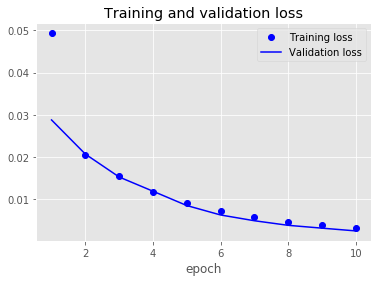

In [71]:
print(model.summary())
plot_training_history(history_opt)

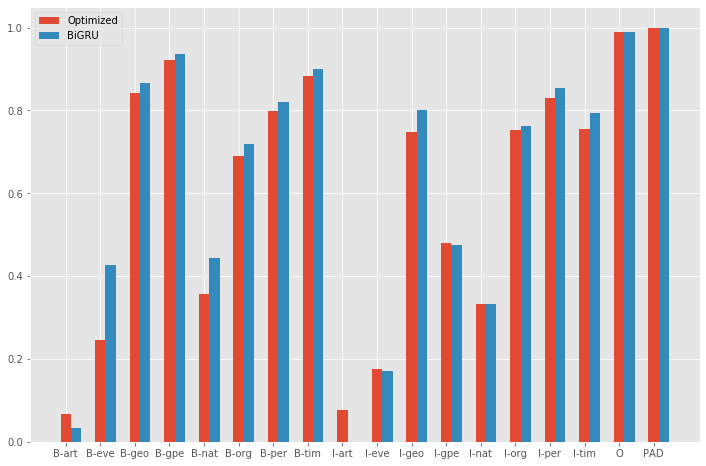

In [72]:
opt = load_keras_model("model_opt")
pred_opt = np.argmax(opt.predict(X_te),axis=2)
opt_F1 = f1_score(label_te.flatten(), pred_opt.flatten(), average=None)
t = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
plt.figure(figsize=(12,8))
plt.bar(t, opt_F1,alpha=1,width=0.3,label='Optimized')
plt.bar(t+0.3, BiGRU_F1,alpha=1,width=0.3,label='BiGRU')
plt.title = 'F1_score'
plt.xticks(t,tags)
plt.legend()

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.

*your answer here*
For those tags with low F1 score, they all have realatively small sample size (see the table below). Therefore we tried to balance the data by resampling those sentences with less-frequent tags. By adding more weights to those sentences with rare tag and merging the resampled data with the original data, we get a new agumented data with occurences of each tags shown below in the bar plot. We change the structure of the network by adding more units to the BiGRU and extend the dimension of embeddings. However, non of the changes mentioned significantly improve the accuracy. Except that, we tried LSTM, multi-layer BiGRU and Adam optimizer, but none of them work. Maybe the data in rare tags like B-art and I-art are too insufficient for our model to learn something from them. Another explaination may be that those named entities have more than one meaning, e.g. the "Street" in "The Wall Street Jornal", could refer to other tag, say "I-org" in other more common contexts, but refer to "I-art" in rare contexts, therefore, our model tend to classify "Street" into "I-org" instead of "I-art".

In [73]:
tag_count=pd.DataFrame(data.groupby(['Tag']).count().values[:,0],index=data.groupby(['Tag']).count().index,columns=['count'])
tag_count

,count
Tag,
B-art,402
B-eve,308
B-geo,37644
B-gpe,15870
B-nat,201
B-org,20143
B-per,16990
B-tim,20333
I-art,297


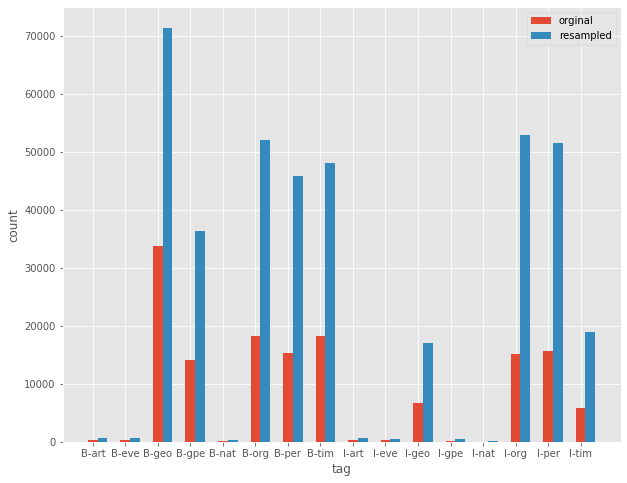

In [74]:
t = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
tag_count=y_tr.sum(axis=0).sum(axis=0)
tag_aug_count=y_tr_aug.sum(axis=0).sum(axis=0)
plt.figure(figsize=(10,8))
plt.bar(t,tag_count[0:(len(tag_count)-2)],width=0.3,label='orginal')
plt.bar(t+0.3,tag_aug_count[0:(len(tag_aug_count))-2],width=0.3,label='resampled')
plt.xticks(t,tags[0:16])
plt.xlabel("tag")
plt.ylabel("count")
plt.legend()